# New loss: using the gram matrix

In [1]:
from torchvision import models
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2 as cv2 # opencv computer vision library
from PIL import Image
import os
import sys
from typing import Dict, Any

dirname = os.path.abspath(os.path.join(os.getcwd(), "..", "lib"))
sys.path.append(dirname)

from display import imshow
from vgg import VGGFeatures
from utils import preprocess, deprocess, normalize
from data import ImageFolderDataset
from DeepStyleX import DeepStyleX

## Importing the dataset and style images

In [2]:
images_dataset = ImageFolderDataset("../data/scenes", transform=preprocess)

# Style
eye_style = Image.open("../data/style/eye.jpg")
abstract_style = Image.open("../data/style/abstract1.jpg")

slider_idx = 0

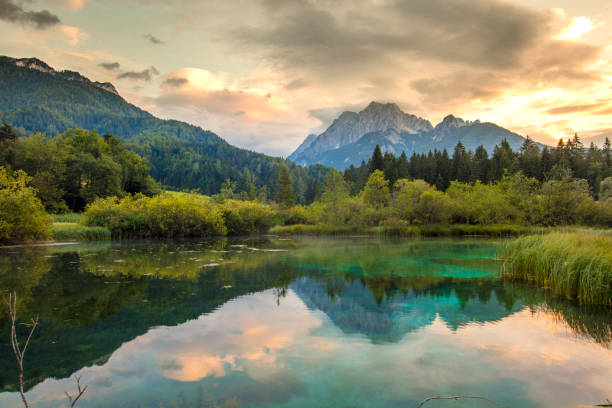

In [3]:
slider_idx=(slider_idx+1)%len(images_dataset)
images_dataset.get_raw(slider_idx)

## Creating the DeepStyleX model and the feature model

In [55]:
deep_style_model = DeepStyleX(batch_norm=True)  # Here we still use the Batch Norm, we will change it later
vgg_model = VGGFeatures(layers=['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3','relu5_3'])
print("Models initialized")

Models initialized


### Choosinge the style

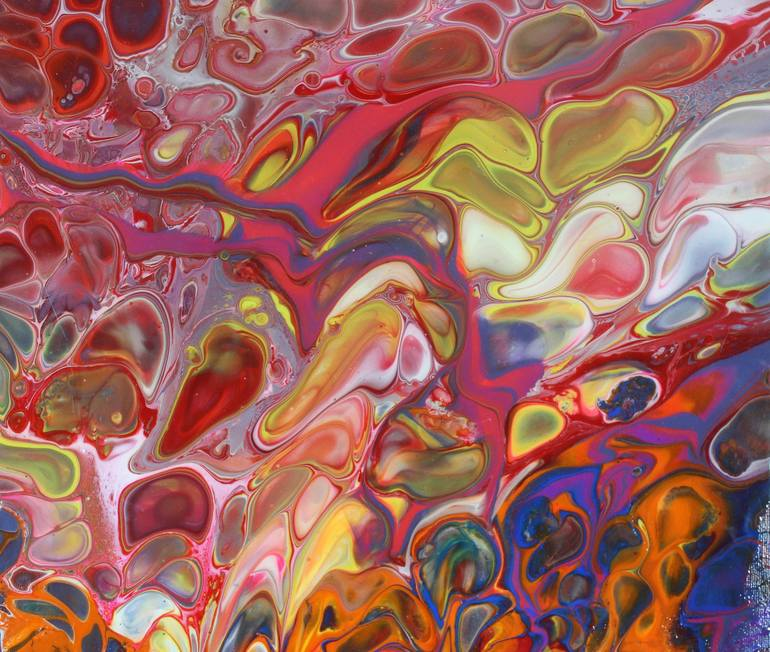

In [56]:
style_image = abstract_style
feature_style = vgg_model(normalize(preprocess(style_image)))
style_image

### Testing the model

In [6]:
idx = 0

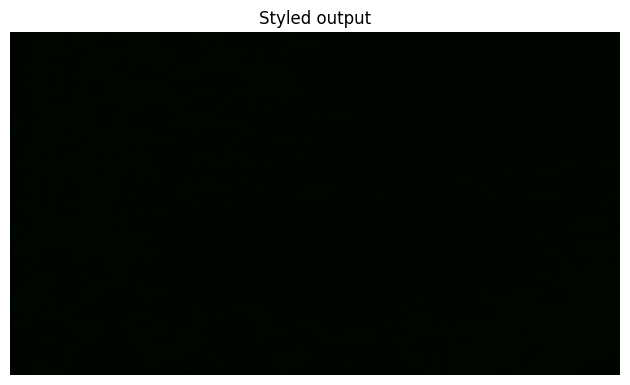

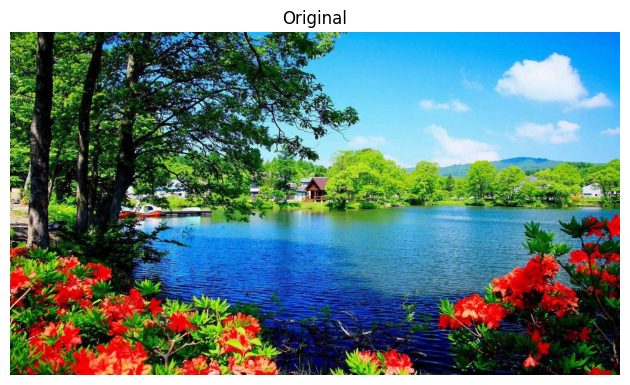

In [7]:
deep_style_model.eval()
input_image_raw = images_dataset.get_raw(idx)

input_image = preprocess(input_image_raw).unsqueeze(0)
output = deep_style_model(input_image)
output_image = deprocess(output)
output_image = output_image.resize(input_image_raw.size)
imshow([output_image],["Styled output"])
imshow([input_image_raw],["Original"])

idx = (idx+1)%len(images_dataset)

## The new loss function
We will now implement the new loss function.
### The gram function

In [8]:
def gram_matrix(X: torch.Tensor):
    if len(X.shape)==4:
        (b, ch, h, w) = X.shape
        features = X.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
    else:
        (ch, h, w) = X.shape
        features = X.view(ch, w * h)
        features_t = features.transpose(0, 1)
        gram = features.matmul(features_t) / (ch * h * w)
    return gram



In [9]:
# Implementatin test
print("The output size for non batch input is:",gram_matrix(feature_style['relu1_2']).shape)
print("The output size for batch input is:",gram_matrix(feature_style['relu1_2'].unsqueeze(0)).shape)

The output size for non batch input is: torch.Size([64, 64])
The output size for batch input is: torch.Size([1, 64, 64])


The `gram_matrix` function is now available in `utils`.

### The new loss function

In [10]:
# define the loss
def loss_function(output_features: dict, original_features: dict, style_gram_features: Dict[Any, torch.Tensor], criterion: nn.Module, content_weight: int = 1, style_weight: int = 1):
    content_loss = 0.
    style_loss = 0.
    weights = [1, 1, 1, 1]


    content_loss += content_weight * criterion(output_features['relu2_2'], original_features['relu2_2'])

    for feature, w in zip(output_features.keys(),weights):
        gm_y = gram_matrix(output_features[feature])
        style_loss += criterion(gm_y, style_gram_features[feature]) * w
    style_loss *= style_weight

    return content_loss + style_loss

In [44]:
# Defining hyper parameters

content_weight = 5
style_weight = 15

batch_size = 3

learning_rate = 4e-4

dataloader = DataLoader(images_dataset, batch_size=batch_size, shuffle=True)

mse_loss = nn.MSELoss()

In [12]:
output = deep_style_model(input_image)


style_gram_features = dict()
for feature in feature_style.keys():
    style_gram_features[feature] = gram_matrix(feature_style[feature]).repeat(1, 1, 1)

with torch.no_grad():
    original_features = vgg_model(normalize(input_image))
output_features = vgg_model(normalize(output))


loss_function(output_features,original_features,style_gram_features,mse_loss)

tensor(12.1196, grad_fn=<AddBackward0>)

### The training function

In [58]:
def train(model: nn.Module, epoch, lr= 1e-3):
    batch_size = dataloader.batch_size
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    criterion = nn.MSELoss()
    model.train()

    style_gram_features = dict()
    for feature in feature_style.keys():
        style_gram_features[feature] = gram_matrix(feature_style[feature]).repeat(batch_size, 1, 1)

    for i in range(epoch):
        for j, batch_images in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(batch_images)
            with torch.no_grad():
                original_features = vgg_model(normalize(batch_images))
            output_features = vgg_model(normalize(output))

            loss = loss_function(output_features, original_features, style_gram_features, criterion, content_weight=content_weight, style_weight=style_weight)

            loss.backward()
            optimizer.step()
            print(str(i+1),'->',j,':',loss.item())

## Training

In [70]:
train(deep_style_model,4, lr=learning_rate)

1 -> 0 : 22.207300186157227
1 -> 1 : 45.835506439208984
2 -> 0 : 25.83184242248535
2 -> 1 : 32.27604675292969
3 -> 0 : 34.91739273071289
3 -> 1 : 20.199047088623047
4 -> 0 : 31.816112518310547
4 -> 1 : 19.60580825805664


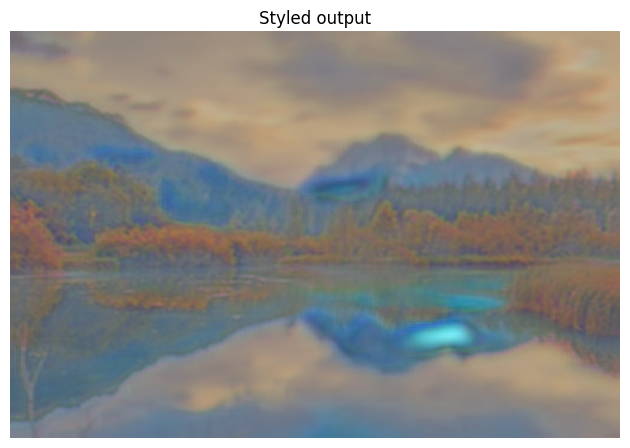

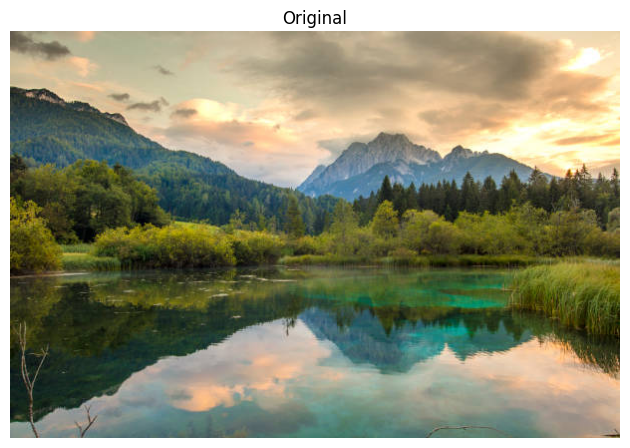

In [76]:
deep_style_model.eval()
input_image_raw = images_dataset.get_raw(idx)

input_image = preprocess(input_image_raw).unsqueeze(0)
output = deep_style_model(input_image)
output_image = deprocess(output)
output_image = output_image.resize(input_image_raw.size)
imshow([output_image],["Styled output"])
imshow([input_image_raw],["Original"])

idx = (idx+1)%len(images_dataset)

In [31]:
outside_image = Image.open("../data/Central-Park.jpg")

array([[<Axes: title={'center': 'Original'}>]], dtype=object)

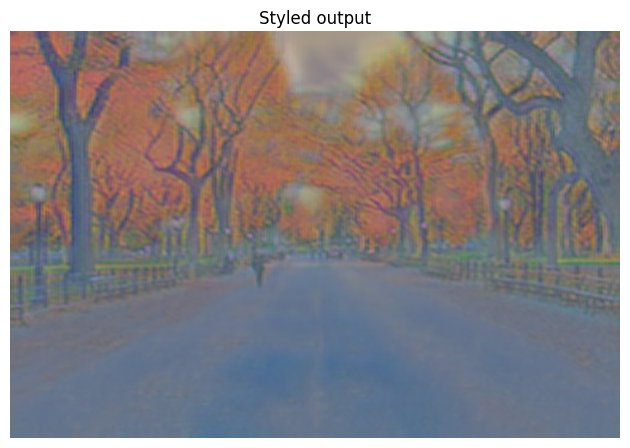

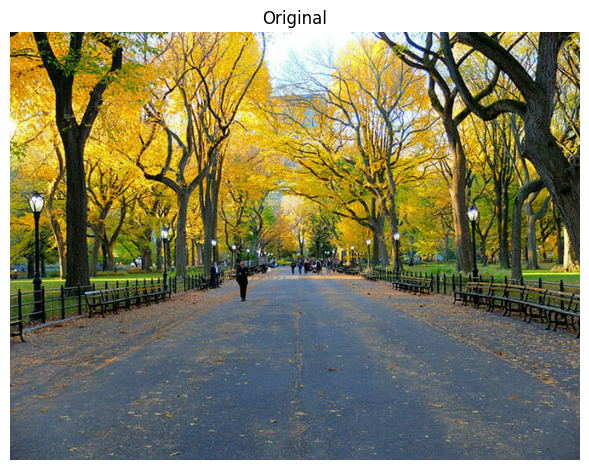

In [77]:
input_image = preprocess(outside_image).unsqueeze(0)
output = deep_style_model(input_image)
output_image = deprocess(output)
output_image = output_image.resize(input_image_raw.size)
imshow([output_image],["Styled output"])
imshow([outside_image],["Original"])